In [35]:
from neucube import Reservoir
from neucube.encoder import RateEncoder
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
from neucube.datamanager import DataManager
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [36]:
params = {
            'source_data_path': 'example_data/labquake_source',
            'samples_path':'example_data/labquake_samples',
            'sampling_rate': 5000,
            'batch_duration': 12000,
    
        }
datamanager = DataManager(params)

In [37]:
filenameslist = ['sample_'+str(idx)+'.csv' for idx in range(20,50)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/labquake_samples/'+filename, header=0))

fulldf = pd.concat(dfs)

In [38]:
fulldf

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10,...,Channel_16,Channel_17,Channel_18,Channel_19,Channel_20,Channel_21,Channel_22,Channel_23,Channel_24,Channel_25
0,1.894531,3.218984,0.010184,0.003747,0.004952,0.000875,0.005361,0.009187,0.016997,-12.811875,...,-9.475000,-12.084687,1.896172,1.147266,-8.387812,0.000070,0.000430,0.000102,0.000047,0.000180
1,1.894844,3.219063,0.010177,0.003744,0.004961,0.000895,0.005356,0.009195,0.016980,-12.812812,...,-9.476250,-12.085625,1.895859,1.147656,-8.389062,0.000078,0.000383,0.000078,0.000047,0.000195
2,1.894375,3.218984,0.010214,0.003742,0.004944,0.000884,0.005358,0.009192,0.016992,-12.814062,...,-9.477187,-12.086250,1.895391,1.147734,-8.389063,-0.000117,0.000344,0.000039,0.000023,0.000133
3,1.894688,3.218906,0.010197,0.003756,0.004955,0.000891,0.005344,0.009203,0.017009,-12.815625,...,-9.478125,-12.087500,1.895781,1.146328,-8.389687,0.000125,0.000406,0.000133,0.000117,0.000219
4,1.894297,3.218906,0.010197,0.003761,0.004953,0.000880,0.005341,0.009194,0.017011,-12.816250,...,-9.479062,-12.088437,1.896406,1.148125,-8.390625,0.000117,0.000367,0.000055,0.000070,0.000172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.873906,3.291797,0.010573,0.003727,0.005108,0.000745,0.005205,0.008948,0.017397,-10.125937,...,-9.682187,-13.960937,1.873906,1.132187,-8.326250,0.000070,0.000453,0.000141,0.000086,0.000234
596,1.872813,3.291875,0.010572,0.003720,0.005122,0.000755,0.005220,0.008928,0.017381,-10.125937,...,-9.682188,-13.961250,1.875000,1.131250,-8.326875,0.000211,0.000570,0.000227,0.000172,0.000336
597,1.873906,3.291953,0.010563,0.003694,0.005100,0.000748,0.005216,0.008950,0.017370,-10.126250,...,-9.683125,-13.961562,1.875156,1.131563,-8.327187,0.000094,0.000469,0.000109,0.000063,0.000227
598,1.873281,3.291875,0.010552,0.003713,0.005111,0.000762,0.005227,0.008942,0.017389,-10.126563,...,-9.683437,-13.962188,1.875234,1.131406,-8.327812,0.000078,0.000461,0.000117,0.000063,0.000258


In [39]:
X = torch.tensor(fulldf.values.reshape(30, 600, 25))  # Check if reshaping is correctly matching your dataset
derivatives = torch.diff(X, dim=1)
min_values = derivatives.min(dim=1)[0].min(dim=0)[0]
max_values = derivatives.max(dim=1)[0].max(dim=0)[0]

encoder = RateEncoder(min_values, max_values, max_rate=1)
negative_spikes = encoder.encode(X)

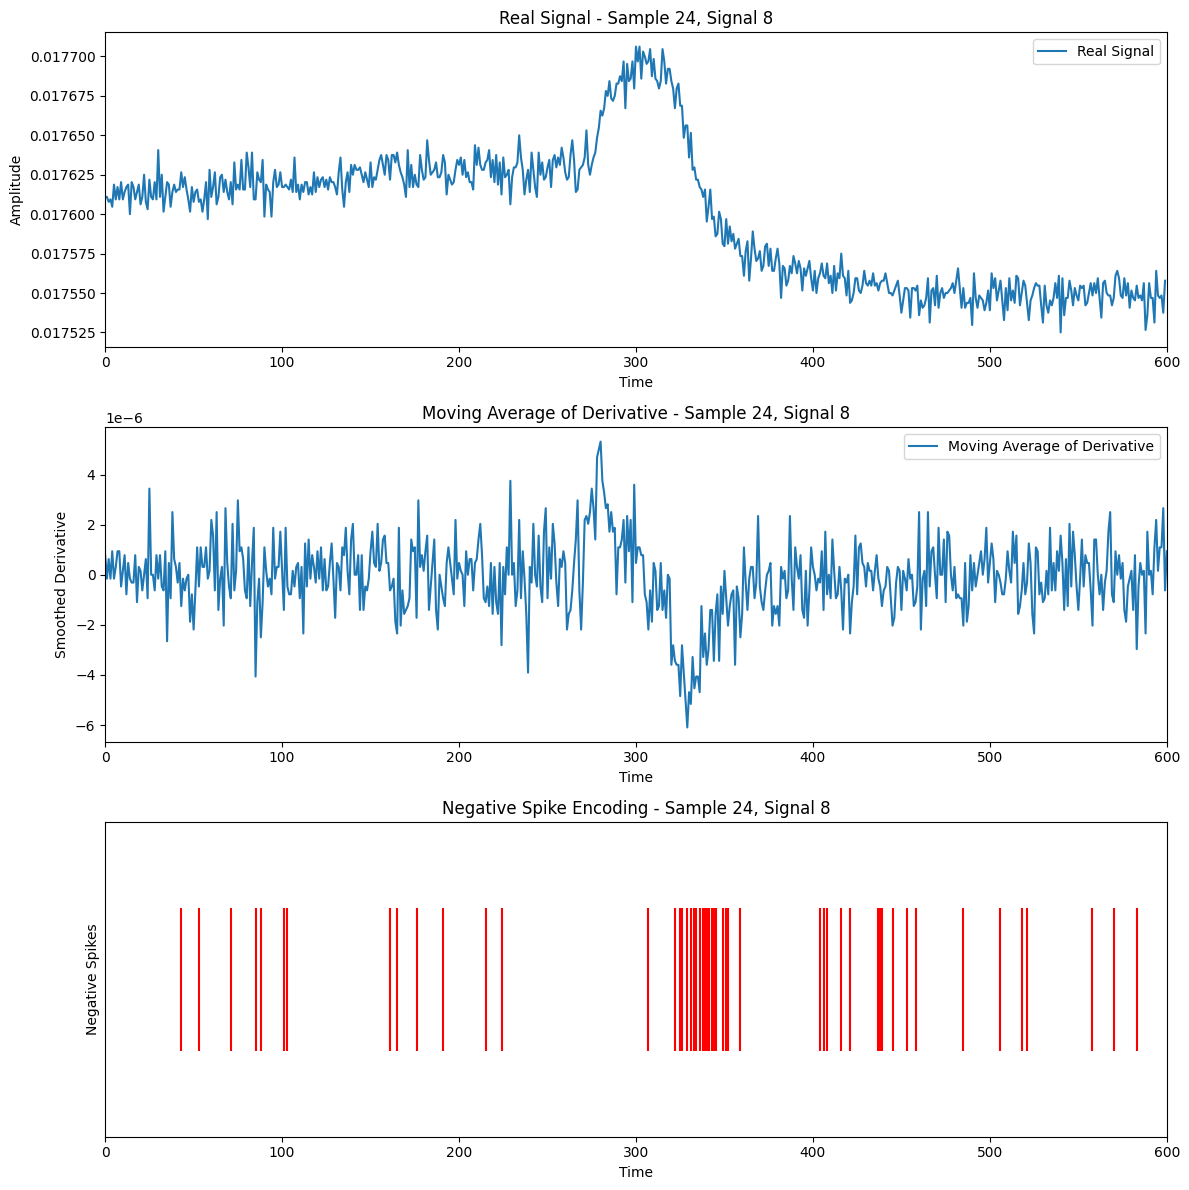

In [53]:
def moving_average(data, window_size=10):
    if window_size < 2:
        return data
    # Ensure data is in float format for convolution operation
    data = data.float()  # Ensure the input data is of type float
    weights = torch.ones(window_size).float() / window_size  # Ensure weights are of type float
    return torch.nn.functional.conv1d(data.unsqueeze(0).unsqueeze(0), weights.unsqueeze(0).unsqueeze(0), padding=window_size//2).squeeze()

def plot_signal_and_encoding(X, neg_sX, sample_index, signal_index, window_size=10):
    plt.figure(figsize=(12, 12))

    # Get the x-axis limits (time steps)
    xlim = (0, X.shape[1])

    # Plotting the real signal
    plt.subplot(3, 1, 1)
    plt.plot(X[sample_index, :, signal_index], label='Real Signal')
    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Real Signal - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    # Calculating and plotting the derivative of the signal
    plt.subplot(3, 1, 2)
    derivative = torch.diff(X[sample_index, :, signal_index], dim=0)
    derivative_padded = torch.cat([derivative, torch.tensor([0.0], dtype=torch.float)])  # Padding to match the original length

    # Calculating the moving average of the derivative
    moving_avg_derivative = moving_average(derivative_padded, window_size)

    plt.plot(moving_avg_derivative, label='Moving Average of Derivative')
    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Moving Average of Derivative - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Smoothed Derivative')
    plt.legend()

    # Plotting the positive spike encoding using eventplot
    plt.subplot(3, 1, 3)
    spike_times_neg = torch.where(neg_sX[sample_index, :, signal_index] == 1)[0]
    plt.eventplot(spike_times_neg, orientation='horizontal', colors='red', linelengths=1)
    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Negative Spike Encoding - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Negative Spikes')
    plt.yticks([])  # Hide y-axis labels since there's only one line

    plt.tight_layout()
    plt.show()

# Example usage: plot signal and encoding for sample 0, signal 0
plot_signal_and_encoding(X, negative_spikes, sample_index=24, signal_index=8)